In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/huggingface-bert/bert-base-multilingual-cased/config.json
/kaggle/input/huggingface-bert/bert-base-multilingual-cased/tokenizer.json
/kaggle/input/huggingface-bert/bert-base-multilingual-cased/tf_model.h5
/kaggle/input/huggingface-bert/bert-base-multilingual-cased/pytorch_model.bin
/kaggle/input/huggingface-bert/bert-base-multilingual-cased/modelcard.json
/kaggle/input/huggingface-bert/bert-base-multilingual-cased/vocab.txt
/kaggle/input/huggingface-bert/bert-large-uncased/config.json
/kaggle/input/huggingface-bert/bert-large-uncased/tokenizer.json
/kaggle/input/huggingface-bert/bert-large-uncased/tf_model.h5
/kaggle/input/huggingface-bert/bert-large-uncased/pytorch_model.bin
/kaggle/input/huggingface-bert/bert-large-uncased/modelcard.json
/kaggle/input/huggingface-bert/bert-large-uncased/vocab.txt
/kaggle/input/huggingface-bert/bert-large-uncased/whole-word-masking/._bert_config.json
/kaggle/input/huggingface-bert/bert-large-uncased/whole-word-masking/bert_config.json
/k

In [2]:
import numpy as np
import pandas as pd
import ast
from itertools import chain
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GroupKFold

import torch
from torch.utils.data import Dataset
from transformers import AutoModel, AutoTokenizer

from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
root = "../input/nbme-score-clinical-patient-notes"

In [4]:
def create_train_df():
    '''
    preprocessing and merge all training data
    Returns : merged data
    '''
    features = pd.read_csv(root+"/features.csv")
    features.loc[27, 'feature_text'] = 'Last-Pap-smear-1-year-ago'
    notes = pd.read_csv(root+"/patient_notes.csv")
    train = pd.read_csv(root+"/train.csv")
    train['annotation'] = train['annotation'].apply(ast.literal_eval)
    train['location'] = train['location'].apply(ast.literal_eval)
    train = train.merge(features, on=['feature_num', 'case_num'], how='left')
    train = train.merge(notes, on=['pn_num', 'case_num'], how='left')
    
    return train
    
    
data = create_train_df()

Fold = GroupKFold(n_splits=5)
groups = data['pn_num'].values
for n, (train_index, val_index) in enumerate(Fold.split(data, data['location'], groups)):
    data.loc[val_index, 'fold'] = int(n)
data['fold'] = data['fold'].astype(int)     


data

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,fold
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,4
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...,4
2,00016_002,0,16,2,[chest pressure],[203 217],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...,4
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...,4
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258],Lightheaded,HPI: 17yo M presents with palpitations. Patien...,4
...,...,...,...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[],Family-history-of-migraines,Stephanie madden is a 20 year old woman compla...,4
14296,95333_913,9,95333,913,[],[],Female,Stephanie madden is a 20 year old woman compla...,4
14297,95333_914,9,95333,914,[photobia],[274 282],Photophobia,Stephanie madden is a 20 year old woman compla...,4
14298,95333_915,9,95333,915,[no sick contacts],[421 437],No-known-illness-contacts,Stephanie madden is a 20 year old woman compla...,4


In [5]:
data['location'].iloc[1]

['668 693']

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [7]:
vocab_size = tokenizer.vocab_size
vocab_size

30522

In [8]:
def calc_max_length(df, tokenizer):
    '''
    Calculate the max length of all sentences in training data
    Parameters:
        df: training data
        tokenizer: pretrained tokenizer
    Returns:
        the sum of max length of patient history and feature text
    '''
    history_length = []
    feature_length = []
    text1 = df['pn_history'].fillna("").values
    text2 = df['feature_text'].fillna("").values
    for i, j in zip(text1, text2):
        history_length.append(len(tokenizer(i, add_special_tokens=False)['input_ids']))
        feature_length.append(len(tokenizer(j, add_special_tokens=False)['input_ids']))
    return max(history_length)+max(feature_length)+3
        
max_length = calc_max_length(data, tokenizer)
print(max_length)

312


In [9]:
def create_label(text, feature, location_list):
    '''
    Convert the character level location into word level label and get input
    Parameters:
        text: patient history in train data
        feature: feature text in train data
        location_list: location in train data
    Returns:
        tokenized input data and label which consists of 0,1,-100
    '''
    inputs = tokenizer(text, feature,
                        add_special_tokens=True,
                        max_length=max_length,
                        padding="max_length",
                        return_offsets_mapping=True)
    inputs["sequence_ids"] = inputs.sequence_ids()
    offset_mapping = inputs["offset_mapping"]
    label = np.zeros(len(offset_mapping))
    for index, (token_id, offset) in enumerate(zip(inputs["sequence_ids"], offset_mapping)):
        if token_id == None or token_id == 1:
            label[index] = -100
            continue
        token_start, token_end = offset
        for i in location_list:
            for loc in [s.split() for s in i.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                if token_start > int(start) and token_end < int(end):
                    label[index] = 1
    
    return inputs, label
                

In [10]:
example_data = data.iloc[1]
print(example_data['location'])
inputs, label = create_label(example_data['pn_history'], example_data['feature_text'], example_data['location'])


['668 693']


In [11]:
class nbme_dataset(Dataset):
    def __init__(self, df):
        self.data = df
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        example = self.data.iloc[item]
        inputs, label = create_label(example['pn_history'], example['feature_text'], example['location'])
        return np.array(inputs["input_ids"]), np.array(inputs["attention_mask"]), np.array(inputs['sequence_ids']).astype("float16"), np.array(inputs["offset_mapping"]), label

In [12]:
class bert_model(torch.nn.Module):
    """Bert model for this project"""
    def __init__(self):
        super().__init__()
        self.backbone = AutoModel.from_pretrained("../input/huggingface-bert/bert-base-uncased")
        self.fc = torch.nn.Linear(768, 1)
        self.dropout = torch.nn.Dropout(p=0.2)
    
    def forward(self, input_ids, attention_mask):
        last_hidden_state = self.backbone(input_ids = input_ids, attention_mask = attention_mask)[0]
        output = self.fc(self.dropout(last_hidden_state)).squeeze(-1)
        return output

In [13]:
class nbme_model_nn(torch.nn.Module):
    """Neural network model for this project"""
    def __init__(self):
        super().__init__()
        self.word_embeddings = torch.nn.Embedding(vocab_size, 300)
        self.linear1 = torch.nn.Linear(300,256)
        self.linear2 = torch.nn.Linear(256,1)
        
    def forward(self,input_ids):
        embeds = self.word_embeddings(input_ids)
        output = self.linear1(embeds)
        output = self.linear2(output)
        return output.squeeze(-1)

In [14]:
class lstm_model(torch.nn.Module):
    """Lstm model for this project"""
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size,300)
        self.lstm = torch.nn.LSTM(300, 312)
        self.linear1 = torch.nn.Linear(312,256)
        self.linear2 = torch.nn.Linear(256,1)
        
    def forward(self,input_ids):
        inputs = self.embedding(input_ids)
        x, _ = self.lstm(inputs, None)
        output = self.linear1(x)
        output = self.linear2(output)
        return output.squeeze(-1)

In [15]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
fold = 0
BATCH_SIZE = 16
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
nn_model = nbme_model_nn().to(device)
lstm_model = lstm_model().to(device)
bert_model = bert_model().to(device)

train_data = data.loc[data['fold'] != fold].reset_index(drop=True)
val_data = data.loc[data['fold'] == fold].reset_index(drop=True)

train = nbme_dataset(train_data)
val = nbme_dataset(val_data)
train_dl = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, pin_memory = True, shuffle = True, drop_last = True)
valid_dl = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, pin_memory = True, shuffle = False, drop_last = False)

Some weights of the model checkpoint at ../input/huggingface-bert/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(nn_model.parameters(), lr = 1e-5)
nn_loss = []
for epoch in range(epochs):
    nn_model.train()
    train_loss = AverageMeter()
    for m in tqdm(train_dl):
        inputs = m[0].to(device)
        labels = m[4].to(device)
        predict = nn_model(inputs)
        loss_fct = torch.nn.BCEWithLogitsLoss(reduction = "none")
        loss = loss_fct(predict, labels)
        loss = torch.masked_select(loss, labels > -1).mean()
        loss.backward()
        optimizer.step()
        train_loss.update(val = loss.item(), n = len(inputs))
        optimizer.zero_grad()
    nn_loss.append(train_loss.avg)
    print(epoch, train_loss.avg)

100%|██████████| 715/715 [00:25<00:00, 28.32it/s]


0 0.5224170021567316


100%|██████████| 715/715 [00:24<00:00, 29.31it/s]


1 0.35396581467427274


100%|██████████| 715/715 [00:23<00:00, 29.98it/s]


2 0.2712135445435105


100%|██████████| 715/715 [00:24<00:00, 28.95it/s]


3 0.21934493416452133


100%|██████████| 715/715 [00:24<00:00, 29.42it/s]


4 0.18256418626311563


100%|██████████| 715/715 [00:24<00:00, 29.20it/s]


5 0.1547514969597577


100%|██████████| 715/715 [00:23<00:00, 29.96it/s]


6 0.1328908109004355


100%|██████████| 715/715 [00:24<00:00, 29.39it/s]


7 0.11527356297827235


100%|██████████| 715/715 [00:24<00:00, 28.95it/s]


8 0.10085844336667106


100%|██████████| 715/715 [00:24<00:00, 29.55it/s]

9 0.08892974400309736


In [18]:
nn_model.eval()
preds1 = []
offsets1 = []
seq_ids1 = []
lbls1 = []
with torch.no_grad():
    for m in tqdm(valid_dl):
        inputs = m[0].to(device)
        labels = m[4].to(device)
        logits = nn_model(inputs)
        preds1.append(logits.cpu().numpy())
        offsets1.append(m[3].numpy())
        seq_ids1.append(m[2].numpy())
        lbls1.append(labels.cpu().numpy())

100%|██████████| 179/179 [00:05<00:00, 33.95it/s]


In [19]:
torch.save(nn_model.state_dict(), "nn.pt")

In [20]:
preds1 = np.concatenate(preds1, axis = 0)
offsets1 = np.concatenate(offsets1, axis = 0)
seq_ids1 = np.concatenate(seq_ids1, axis = 0)
lbls1 = np.concatenate(lbls1, axis = 0)

In [21]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr = 1e-5)
lstm_loss = []
for epoch in range(epochs):
    lstm_model.train()
    train_loss = AverageMeter()
    for m in tqdm(train_dl):
        inputs = m[0].to(device)
        labels = m[4].to(device)
        predict = lstm_model(inputs)
        loss_fct = torch.nn.BCEWithLogitsLoss(reduction = "none")
        loss = loss_fct(predict, labels)
        loss = torch.masked_select(loss, labels > -1).mean()
        loss.backward()
        optimizer.step()
        train_loss.update(val = loss.item(), n = len(inputs))
        optimizer.zero_grad()
    lstm_loss.append(train_loss.avg)
    print(epoch, train_loss.avg)

100%|██████████| 715/715 [00:28<00:00, 25.26it/s]


0 0.3034160935416851


100%|██████████| 715/715 [00:28<00:00, 24.99it/s]


1 0.08779670990642797


100%|██████████| 715/715 [00:27<00:00, 25.69it/s]


2 0.06611906930872646


100%|██████████| 715/715 [00:28<00:00, 25.07it/s]


3 0.055282034509703516


100%|██████████| 715/715 [00:28<00:00, 25.20it/s]


4 0.04924533328617054


100%|██████████| 715/715 [00:28<00:00, 24.89it/s]


5 0.04558541362488543


100%|██████████| 715/715 [00:28<00:00, 24.76it/s]


6 0.04346493909996819


100%|██████████| 715/715 [00:28<00:00, 24.85it/s]


7 0.04191861269599589


100%|██████████| 715/715 [00:29<00:00, 24.63it/s]


8 0.04084800148075418


100%|██████████| 715/715 [00:28<00:00, 25.20it/s]

9 0.04006424077207284


In [22]:
torch.save(lstm_model.state_dict(), "lstm.pt")

In [23]:
lstm_model.eval()
preds2 = []
offsets2 = []
seq_ids2 = []
lbls2 = []
with torch.no_grad():
    for m in tqdm(valid_dl):
        inputs = m[0].to(device)
        labels = m[4].to(device)
        logits = lstm_model(inputs)
        preds2.append(logits.cpu().numpy())
        offsets2.append(m[3].numpy())
        seq_ids2.append(m[2].numpy())
        lbls2.append(labels.cpu().numpy())

100%|██████████| 179/179 [00:05<00:00, 29.93it/s]


In [24]:
preds2 = np.concatenate(preds2, axis = 0)
offsets2 = np.concatenate(offsets2, axis = 0)
seq_ids2 = np.concatenate(seq_ids2, axis = 0)
lbls2 = np.concatenate(lbls2, axis = 0)

In [25]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(bert_model.parameters(), lr = 1e-5)
bert_loss = []

for epoch in range(epochs):
    bert_model.train()
    train_loss = AverageMeter()
    for m in tqdm(train_dl):
        inputs = m[0].to(device)
        attention_mask = m[1].to(device)
        labels = m[4].to(device)
        predict = bert_model(inputs, attention_mask)
        loss_fct = torch.nn.BCEWithLogitsLoss(reduction = "none")
        loss = loss_fct(predict, labels)
        loss = torch.masked_select(loss, labels > -1).mean()
        loss.backward()
        optimizer.step()
        train_loss.update(val = loss.item(), n = len(inputs))
        optimizer.zero_grad()
    bert_loss.append(train_loss.avg)
    print(epoch, train_loss.avg)

100%|██████████| 715/715 [06:31<00:00,  1.83it/s]


0 0.036247783430580306


100%|██████████| 715/715 [06:30<00:00,  1.83it/s]


1 0.01780333685825815


100%|██████████| 715/715 [06:31<00:00,  1.83it/s]


2 0.01252327534280461


100%|██████████| 715/715 [06:31<00:00,  1.83it/s]


3 0.009615893895897277


100%|██████████| 715/715 [06:30<00:00,  1.83it/s]


4 0.007703475326453203


100%|██████████| 715/715 [06:31<00:00,  1.83it/s]


5 0.006146018892208467


100%|██████████| 715/715 [06:32<00:00,  1.82it/s]


6 0.004970317665289673


100%|██████████| 715/715 [06:31<00:00,  1.82it/s]


7 0.004107565937651289


100%|██████████| 715/715 [06:32<00:00,  1.82it/s]


8 0.003378770847620614


100%|██████████| 715/715 [06:32<00:00,  1.82it/s]

9 0.002871411532589652


In [26]:
torch.save(bert_model.state_dict(), "bert.pt")

In [27]:
bert_model.eval()
preds = []
offsets = []
seq_ids = []
lbls = []
with torch.no_grad():
    for m in tqdm(valid_dl):
        inputs = m[0].to(device)
        attention_mask = m[1].to(device)
        labels = m[4].to(device)
        logits = bert_model(inputs, attention_mask)
        preds.append(logits.cpu().numpy())
        offsets.append(m[3].numpy())
        seq_ids.append(m[2].numpy())
        lbls.append(labels.cpu().numpy())

100%|██████████| 179/179 [00:36<00:00,  4.87it/s]


In [28]:
preds = np.concatenate(preds, axis = 0)
offsets = np.concatenate(offsets, axis = 0)
seq_ids = np.concatenate(seq_ids, axis = 0)
lbls = np.concatenate(lbls, axis = 0)

In [29]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [30]:
def get_loc_from_pred(preds, offsets, seq_ids):
    '''
    get the character level location from prediction
    Parameters:
        preds: the output of our model
        offsets: the offsets from tokenized input sentence
        seq_ids: the sequence id from tokenized input sentence
    Returns:
        the character level location list
    '''
    prediction = []
    flag = 0
    for i in range(preds.shape[0]):
        temp_pred = []
        pred = sigmoid(preds[i])
        start = None
        for j in range(preds.shape[1]):
            if seq_ids[i][j] == None or seq_ids[i][j] == 1:
                continue
            if pred[j] > 0.5:
                if start == None:
                    start = offsets[i][j][0]
                end = offsets[i][j][1]
            elif start != None:
                temp_pred.append((int(start), int(end)))
                start = None
        
        prediction.append(temp_pred)
                
    return prediction

In [31]:
def evaluate(pred_location, offsets, seq_id, labels):
    '''
    get the precision, recall, f1 score of the prediction
    Parameters:
        pred_location: the prediction location
        offsets: the offsets from tokenized input sentence
        seq_ids: the sequence id from tokenized input sentence
        labels: word level labels which consist of 0,1,-100
    Returns:
        precision, recall, f1 score
    '''
    label = []
    prediction = []
    for i in range(labels.shape[0]):
        character = max(list(chain(*offsets[i])))
        char_label = np.zeros((character))
        char_pred = np.zeros((character))
        for j in range(labels.shape[1]):
            if seq_id[i][j] == None or seq_id[i][j] == 1:
                continue
            if int(labels[i][j]) == 1:
                char_label[offsets[i][j][0]:offsets[i][j][1]] = 1
        if len(pred_location[i]) != 0:  
            for (start, end) in pred_location[i]:
                char_pred[start:end] = 1
        label.extend(char_label)
        prediction.extend(char_pred)
    results = precision_recall_fscore_support(label, prediction, average='binary')
    return results

In [32]:
prediction1 = get_loc_from_pred(preds1, offsets1, seq_ids1)
result1 = evaluate(prediction1, offsets1, seq_ids1, lbls1)
result1

(0.005381270837801478, 0.021393690411596, 0.008599470322480136, None)

In [33]:
prediction2 = get_loc_from_pred(preds2, offsets2, seq_ids2)
result2 = evaluate(prediction2, offsets2, seq_ids2, lbls2)
result2

(0.0, 0.0, 0.0, None)

In [34]:
prediction = get_loc_from_pred(preds, offsets, seq_ids)
result = evaluate(prediction, offsets, seq_ids, lbls)
result

(0.6578683115765314, 0.7109526393302845, 0.6833811421972209, None)

In [35]:
nn_loss

[0.5224170021567316,
 0.35396581467427274,
 0.2712135445435105,
 0.21934493416452133,
 0.18256418626311563,
 0.1547514969597577,
 0.1328908109004355,
 0.11527356297827235,
 0.10085844336667106,
 0.08892974400309736]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


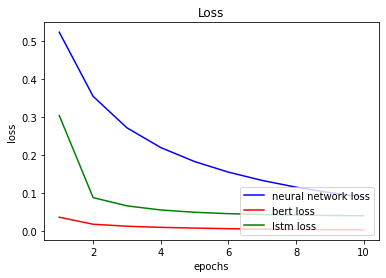

In [36]:
x = np.linspace(1, 10, 10)
print(x)
plt.plot(x, np.array(nn_loss), color='b', label='neural network loss')
plt.plot(x, bert_loss, color='r', label='bert loss')
plt.plot(x, lstm_loss, color='green', label='lstm loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc='lower right')
plt.show()